In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dental-radiography/valid/0245_jpg.rf.c6933f3269649149481b1515759efe33.jpg
/kaggle/input/dental-radiography/valid/0640_jpg.rf.efc8cb9585102f05ae778a77fd63389f.jpg
/kaggle/input/dental-radiography/valid/0985_jpg.rf.2031b8f3a0c8c59ce626d7cc1a73c69e.jpg
/kaggle/input/dental-radiography/valid/0984_jpg.rf.d770424d7e0cbaf0210f900cd7a0a37b.jpg
/kaggle/input/dental-radiography/valid/0091_jpg.rf.63aed96fec3e4c67b25d53034ed4c12d.jpg
/kaggle/input/dental-radiography/valid/0899_jpg.rf.9aa0303d14013b8904172664ee318ea0.jpg
/kaggle/input/dental-radiography/valid/0825_jpg.rf.a36d73e17d7a1da6435245915ea9f14f.jpg
/kaggle/input/dental-radiography/valid/0598_jpg.rf.b103fda6f6879877e14619babd253df1.jpg
/kaggle/input/dental-radiography/valid/0021_jpg.rf.0d2cd31b4786f6121d2241aa8c595bf9.jpg
/kaggle/input/dental-radiography/valid/0779_jpg.rf.5e81e083ec3f39a4653caca440ece538.jpg
/kaggle/input/dental-radiography/valid/0288_jpg.rf.7576a9c760c217036a5ab1a7db10d2c7.jpg
/kaggle/input/dental-radiography

In [2]:
#Import Libraries
import tensorflow as tf
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def load_data(data_directory):
    images = []
    labels = [] 
    classes = []
    label_encoder = LabelEncoder()

    for class_name in os.listdir(data_directory):
        class_path = os.path.join(data_directory, class_name)
        classes.append(class_name)

        for filename in os.listdir(class_path):
            filepath = os.path.join(class_path, filename)
            img = cv2.imread(filepath)
                   
            if img is not None:
                img = cv2.resize(img, (224, 224))
                img = img / 255.0
                images.append(img)
                labels.append(class_name)
    images = np.array(images)
    labels = label_encoder.fit_transform(labels) 

    return images, labels, classes

In [4]:
data_directory = '/kaggle/input/dental-radiography'
images, labels, classes =load_data(data_directory)

In [5]:
# Update the path to your dataset
train_data_dir = '/kaggle/input/dental-radiography/train'
test_data_dir = '/kaggle/input/dental-radiography/test'
val_data_dir = '/kaggle/input/dental-radiography/valid'

In [6]:
X_train, X_test ,y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to apply augmentation twice to each dataset
def augment_dataset(dataset):
    augmented_data = []
    for img in dataset:
        img = np.expand_dims(img, axis=0)  # Expanding dimensions for batch size
        for _ in range(1):  # Apply augmentation twice
            for batch in datagen.flow(img, batch_size=1):
                augmented_data.append(np.squeeze(batch))  # Remove the batch dimension
                break  # Stop the loop after one augmented image
    return np.array(augmented_data)

X_train_augmented = augment_dataset(X_train)
X_test_augmented = augment_dataset(X_test)
#X_val_augmented = augment_dataset(X_val)
y_train_augmented = np.repeat(y_train, 1, axis=0) 
y_test_augmented = np.repeat(y_test, 1, axis=0)  



# Check the shapes of augmented datasets
print("X_train_augmented shape:", X_train_augmented.shape)
print("X_test_augmented shape:", X_test_augmented.shape)
print("y_train_augmented shape:", y_train_augmented.shape)
print("y_test_augmented shape:", y_test_augmented.shape)

X_train_augmented shape: (1015, 224, 224, 3)
X_test_augmented shape: (254, 224, 224, 3)
y_train_augmented shape: (1015,)
y_test_augmented shape: (254,)


In [9]:
from sklearn.utils import shuffle

# Combine original data with augmented data
X_train_combined = np.concatenate((X_train, X_train_augmented))
y_train_combined = np.concatenate((y_train, y_train_augmented))

X_test_combined = np.concatenate((X_test, X_test_augmented))
y_test_combined = np.concatenate((y_test, y_test_augmented))


# Shuffle the combined data
X_train_combined, y_train_combined = shuffle(X_train_combined, y_train_combined, random_state=42)
X_test_combined, y_test_combined = shuffle(X_test_combined, y_test_combined, random_state=42)

In [10]:
from keras.utils import to_categorical
num_classes = 3 
y_test_categorical = to_categorical(y_test_combined, num_classes=3)

In [11]:
from keras.utils import to_categorical
num_classes = 3 
y_train_categorical = to_categorical(y_train_combined, num_classes=3)

# VGG16

In [12]:
from keras.applications import vgg16


img_rows, img_cols = 224, 224
vgg = vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (224, 224, 3))

for layer in vgg.layers:
     layer.trainable = False


for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

58889256/58889256 [==============================] - 0s 0us/step
0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [13]:
def lw(bottom_model, num_classes):

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(3,activation='softmax')(top_model)
    return top_model

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model


FC_Head = lw(vgg, 3)

model = Model(inputs = vgg.input, outputs = FC_Head)

In [15]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import backend as K
metrics = [
        'accuracy',
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.SpecificityAtSensitivity(0.5),
        tf.keras.metrics.SensitivityAtSpecificity(0.5),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.TruePositives()]

In [17]:
# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_combined)
num_classes = len(label_encoder.classes_)
y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)

In [18]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = metrics)

In [19]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the model
history = model.fit(X_train_combined, y_train_categorical, epochs=10, batch_size=32,validation_split=0.2,)


Epoch 1/10
51/51 [==============================] - 27s 291ms/step - loss: 0.5792 - accuracy: 0.8300 - val_loss: 0.5055 - val_accuracy: 0.8498
Epoch 2/10
51/51 [==============================] - 7s 146ms/step - loss: 0.5175 - accuracy: 0.8430 - val_loss: 0.4800 - val_accuracy: 0.8498
Epoch 3/10
51/51 [==============================] - 7s 146ms/step - loss: 0.4994 - accuracy: 0.8430 - val_loss: 0.4580 - val_accuracy: 0.8498
Epoch 4/10
51/51 [==============================] - 8s 148ms/step - loss: 0.4743 - accuracy: 0.8430 - val_loss: 0.4553 - val_accuracy: 0.8498
Epoch 5/10
51/51 [==============================] - 8s 148ms/step - loss: 0.4561 - accuracy: 0.8430 - val_loss: 0.4583 - val_accuracy: 0.8498
Epoch 6/10
51/51 [==============================] - 8s 150ms/step - loss: 0.4459 - accuracy: 0.8430 - val_loss: 0.4372 - val_accuracy: 0.8498
Epoch 7/10
51/51 [==============================] - 8s 150ms/step - loss: 0.4556 - accuracy: 0.8430 - val_loss: 0.4721 - val_accuracy: 0.8498
Epoch

In [20]:
y_train_combined[3]
X_train_combined = np.array(X_train_combined)
y_train_combined = np.array(y_train_combined).astype('float32')

# densenet

In [21]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet201
import tensorflow as tf
def model_densenet():
    densenet201_base = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in densenet201_base.layers:
        layer.trainable = False
    
    model = models.Sequential()
    model.add(densenet201_base)
    model.add(layers.Flatten())
    
    # Fixed FC layer units and dropout rate
    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    model.add(Dense(3, activation='softmax'))

    metrics = [
        'accuracy',
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.F1Score()
    ]
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
    
    return model

In [22]:
model = model_densenet()

74836368/74836368 [==============================] - 0s 0us/step


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 94080)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                6021184   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 24343363 (92.86 MB)
Trainable params: 6021379 (22.97 MB)
Non-trainable params: 18321984 (69.89 MB)
_________________________________________________________________


In [24]:
# Train the model
history = model.fit(X_train_combined, y_train_categorical, epochs=10, batch_size=32,validation_split=0.2)

Epoch 1/10
51/51 [==============================] - 35s 402ms/step - loss: 7.6409 - accuracy: 0.7488 - auc_1: 0.8404 - recall_1: 0.7297 - precision_1: 0.7582 - false_negatives_1: 439.0000 - false_positives_1: 378.0000 - true_negatives_1: 2870.0000 - true_positives_1: 1185.0000 - f1_score: 0.3573 - val_loss: 0.5749 - val_accuracy: 0.8498 - val_auc_1: 0.9387 - val_recall_1: 0.8498 - val_precision_1: 0.8498 - val_false_negatives_1: 61.0000 - val_false_positives_1: 61.0000 - val_true_negatives_1: 751.0000 - val_true_positives_1: 345.0000 - val_f1_score: 0.3063
Epoch 2/10
51/51 [==============================] - 9s 182ms/step - loss: 0.5027 - accuracy: 0.8442 - auc_1: 0.9342 - recall_1: 0.7709 - precision_1: 0.8599 - false_negatives_1: 372.0000 - false_positives_1: 204.0000 - true_negatives_1: 3044.0000 - true_positives_1: 1252.0000 - f1_score: 0.3183 - val_loss: 0.4422 - val_accuracy: 0.8498 - val_auc_1: 0.9441 - val_recall_1: 0.8498 - val_precision_1: 0.8498 - val_false_negatives_1: 61.00

In [25]:

# Evaluate the model on the validation set
result = model.evaluate(X_test_combined, y_test_categorical)
print("Validation Accuracy:", result[1])


16/16 [==============================] - 6s 375ms/step - loss: 0.4644 - accuracy: 0.8287 - auc_1: 0.9474 - recall_1: 0.7795 - precision_1: 0.8761 - false_negatives_1: 112.0000 - false_positives_1: 56.0000 - true_negatives_1: 960.0000 - true_positives_1: 396.0000 - f1_score: 0.3533
Validation Accuracy: 0.8287401795387268


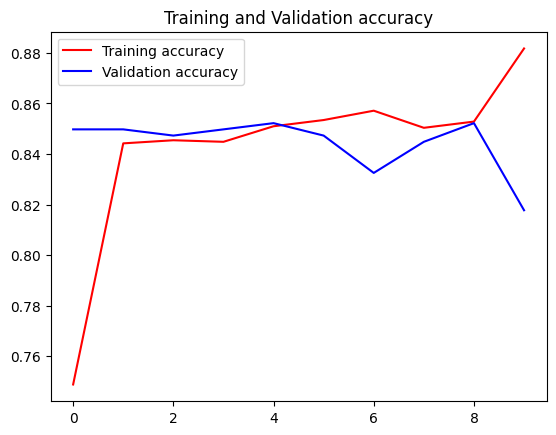

<Figure size 640x480 with 0 Axes>

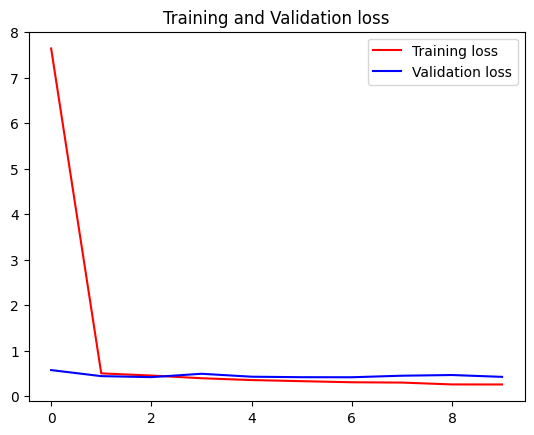

<Figure size 640x480 with 0 Axes>

In [26]:
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',label="Training accuracy")
plt.plot(epochs,val_acc,'b',label="Validation accuracy")
plt.title('Training and Validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.title('Training and Validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()